# Install Dependencies

In [1]:
!pip install efficientnet-pytorch
!pip install torch-optimizer

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached 

In [2]:
from glob import glob

import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import LabelEncoder

import torch
import torchvision
from torch import Tensor
from torchvision import transforms
from torchvision import datasets, models
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import efficientnet_pytorch
import torch_optimizer as optim
import albumentations as A

import sklearn
from tqdm import tqdm

import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Retrieval

In [4]:
!unzip /content/drive/MyDrive/cs444-final-project/project/data/small_data/train.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/08fdd4217a1bc231.jpg  
  inflating: __MACOSX/train/._08fdd4217a1bc231.jpg  
  inflating: train/1ce86af3a48ad68b.jpg  
  inflating: __MACOSX/train/._1ce86af3a48ad68b.jpg  
  inflating: train/1282246e4db471b9.jpg  
  inflating: __MACOSX/train/._1282246e4db471b9.jpg  
  inflating: train/0be6edbe75b6895a.jpg  
  inflating: __MACOSX/train/._0be6edbe75b6895a.jpg  
  inflating: train/0108d9c833113277.jpg  
  inflating: __MACOSX/train/._0108d9c833113277.jpg  
  inflating: train/15c5b86c84c70357.jpg  
  inflating: __MACOSX/train/._15c5b86c84c70357.jpg  
  inflating: train/1aab573525820cb4.jpg  
  inflating: __MACOSX/train/._1aab573525820cb4.jpg  
  inflating: train/0a05495d288a8a0b.jpg  
  inflating: __MACOSX/train/._0a05495d288a8a0b.jpg  
  inflating: train/0a483f22996da2ba.jpg  
  inflating: __MACOSX/train/._0a483f22996da2ba.jpg  
  inflating: train/0ca35cd0e0d7a56c.jpg  
  inflating: __MACOSX/train/._0ca35cd0e0d7a56c.jpg  

In [5]:
!unzip /content/drive/MyDrive/cs444-final-project/project/data/small_data/test.zip


Archive:  /content/drive/MyDrive/cs444-final-project/project/data/small_data/test.zip
   creating: test/
  inflating: __MACOSX/._test         
  inflating: test/05cd51a8acabe799.jpg  
  inflating: __MACOSX/test/._05cd51a8acabe799.jpg  
  inflating: test/081fcd5bc43c74ce.jpg  
  inflating: __MACOSX/test/._081fcd5bc43c74ce.jpg  
  inflating: test/20f51dbec422b415.jpg  
  inflating: __MACOSX/test/._20f51dbec422b415.jpg  
  inflating: test/18d86ead28f1801f.jpg  
  inflating: __MACOSX/test/._18d86ead28f1801f.jpg  
  inflating: test/0408807f220acfd3.jpg  
  inflating: __MACOSX/test/._0408807f220acfd3.jpg  
  inflating: test/07b1ef4cb759334b.jpg  
  inflating: __MACOSX/test/._07b1ef4cb759334b.jpg  
  inflating: test/02e03209141f945c.jpg  
  inflating: __MACOSX/test/._02e03209141f945c.jpg  
  inflating: test/087b94c079d87fec.jpg  
  inflating: __MACOSX/test/._087b94c079d87fec.jpg  
  inflating: test/1e02edbbbe52b984.jpg  
  inflating: __MACOSX/test/._1e02edbbbe52b984.jpg  
  inflating: test/1d

# Hyperparamters

In [20]:
NUM_WORKERS = 2
BATCH_SIZE = 16
MODEL_SAVE_TO = '/content/drive/MyDrive/cs444-final-project/project/models/baselines/saved_models/efficient_net_b7_best_model.pth'
NUM_EPOCHS = 15
LOG_FREQ = 10
NUM_CLASSES = 25
BETAS = (0.9,0.999)
EPS = 1e-3
WEIGHT_DECAY = 1e-4
LR = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset and Dataloader

In [7]:
class LandmarkImageDataset(Dataset):
    def __init__(self, annotations_file, transform=None, id_path_mapping="", is_pt=False):
        """
        Args:
            annotations_file (string): Path to the CSV file with annotations.
            img_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
            file_extension (string, optional): Extension of the image files in the directory.
        """
        self.img_labels = pd.read_csv(annotations_file)
        self.id_to_label = {str(row[0]): row[3] for row in self.img_labels.values}
        self.transform = transform
        self.id_path_mapping = pd.read_csv(id_path_mapping)
        self.length = len(self.id_path_mapping)
        self.is_pt = is_pt


    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # Retrieve the image ID and path from the mapping
        image_id = self.id_path_mapping.iloc[idx]['id']
        image_path = self.id_path_mapping.iloc[idx]['path']

        label = self.id_to_label[str(image_id)]

        if self.is_pt:
            tensor = torch.load(image_path)
            if self.transform:
                tensor = self.transform(tensor)
            return tensor, label
        else:
            # Load the image
            image = Image.open(image_path)
            # Apply transform if any
            if self.transform:
                image = self.transform(image)
            return image, label


# Define transformations for the training data
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_transform_pt = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

label_csv = "/content/drive/MyDrive/cs444-final-project/project/data/small_data/small_data.csv"
train_img_id_to_path_mapping = "/content/drive/MyDrive/cs444-final-project/project/data/small_data/train_img_id_to_path_mapping_drive.csv"
# Create an instance of the dataset
train_dataset = LandmarkImageDataset(
    annotations_file=label_csv,
    transform=train_transform,
    id_path_mapping=train_img_id_to_path_mapping,
    # is_pt=Trued
    is_pt=False
)

# Define the DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)




In [8]:
len(train_dataset)

6731

# Optimzer

In [9]:
def radam(parameters, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
    if isinstance(betas, str):
        betas = eval(betas)
    return optim.RAdam(parameters, lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)

# Evaluation Metrics

In [10]:
class RunningAverage:
    '''
      Computes and keeps track of the running average and the current value of metrics
    '''
    def __init__(self) -> None:
        self.val = 0.0
        self.avg = 0.0
        self.sum = 0.0
        self.count = 0

    def update(self, val: float, n: int = 1) -> None:
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def GAP(predicts: torch.Tensor, confs: torch.Tensor, targets: torch.Tensor) -> float:
    """
    Calculates the simplified Global Average Precision.
    https://www.kaggle.com/competitions/landmark-recognition-2020/overview/evaluation

    Args:
        predicts (torch.Tensor): Predicted labels of shape (n_samples,).
        confs (torch.Tensor): Confidence scores associated with predictions, of shape (n_samples,).
        targets (torch.Tensor): Ground truth labels, of shape (n_samples,).

    Returns:
        float: The GAP score for the given predictions and targets.
    """
    assert len(predicts.shape) == 1 and len(confs.shape) == 1 and len(targets.shape) == 1 and predicts.shape == confs.shape and confs.shape == targets.shape

    _, indices = torch.sort(confs, descending=True)

    confs = confs.cpu().numpy()
    predicts = predicts[indices].cpu().numpy()
    targets = targets[indices].cpu().numpy()

    res, true_pos = 0.0, 0

    for i, (c, p, t) in enumerate(zip(confs, predicts, targets)):
        rel = int(p == t)
        true_pos += rel

        res += true_pos / (i + 1) * rel

    res /= targets.shape[0]
    return res

# Model Initialization

In [11]:
class EfficientNetEncoderHead(nn.Module):
    """
    Defining an EfficientNet encoder head for image classification.

    Attributes:
        depth (int): The depth version of the EfficientNet.
        num_classes (int): The number of classes for the classifier output.
        base (EfficientNet): The base EfficientNet model preloaded with pretrained weights.
        avg_pool (nn.AdaptiveAvgPool2d): Adaptive average pooling to reduce spatial dimensions to 1x1.
        output_filter (int): The number of output features from the EfficientNet.
        classifier (nn.Linear): The linear classifier that outputs the class probabilities.

    Methods:
        forward(x): Defines the forward pass of the model.
    """
    def __init__(self, depth, num_classes):
        super(EfficientNetEncoderHead, self).__init__()
        self.depth = depth
        self.base = efficientnet_pytorch.EfficientNet.from_pretrained(f'efficientnet-b{self.depth}')
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.output_filter = self.base._fc.in_features
        self.classifier = nn.Linear(self.output_filter, num_classes)
    def forward(self, x):
        x = self.base.extract_features(x)
        x = self.avg_pool(x).squeeze(-1).squeeze(-1)
        x = self.classifier(x)
        return x

# Model Training (EfficientNet-b0)

In [12]:
def train(train_loader, model, criterion, optimizer, lr_scheduler, epochs=10):
    train_losses = []
    train_gap = []
    best_score = float('-inf')
    for epoch in range(epochs):
        losses = RunningAverage()
        avg_score = RunningAverage()

        model.train()
        num_batches = len(train_loader)

        lr = None
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}', leave=True)
        for i, (inputs, labels) in enumerate(progress_bar):
            inputs, labels = inputs.to(device), labels.to(device)
            output = model(inputs.cuda())
            loss = criterion(output, labels)
            confs, predicts = torch.max(output.detach(), dim=1)
            avg_score.update(GAP(predicts, confs, labels))
            losses.update(loss.data.item(), inputs.size(0))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            lr = optimizer.param_groups[0]['lr']

            # Update tqdm progress bar description with status
            if i % LOG_FREQ == 0 or i == num_batches - 1:
                progress_desc = (
                    f'Epoch {epoch + 1}/{epochs} - '
                    f'Batch {i + 1}/{num_batches} - '
                    f'Loss: {losses.val:.4f} (Avg: {losses.avg:.4f}) - '
                    f'GAP score: {avg_score.val:.4f} (Avg: {avg_score.avg:.4f}) - '
                    f'Learning Rate: {lr:.6f}'
                )
                progress_bar.set_description(progress_desc)
                progress_bar.refresh()  # to show immediate updates

        # Checkpoint
        if avg_score.avg > best_score:
            best_score = avg_score.avg
            torch.save(model.state_dict(), MODEL_SAVE_TO)
            print(f'Saved new best model with avg GAP: {best_score:.4f}')

        train_gap.append(avg_score.avg)
        train_losses.append(losses.avg)

        # Clear the last progress description to avoid redundancy with the next epoch
        progress_bar.set_description(f'Epoch {epoch+1}/{epochs}')
        progress_bar.refresh()
        print(f'      ==== GAP score in epoch {epoch + 1}: {avg_score.avg:.4f} ===')

    return train_losses, train_gap

In [13]:
model = EfficientNetEncoderHead(depth=7, num_classes=NUM_CLASSES)

criterion = nn.CrossEntropyLoss()
optimizer = radam(model.parameters(), lr=LR, betas=BETAS, eps=EPS, weight_decay=WEIGHT_DECAY)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_loader) * NUM_EPOCHS, eta_min=1e-6)
model.to(device)


train_losses, train_gap = train(train_loader, model, criterion, optimizer, scheduler, NUM_EPOCHS)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth
100%|██████████| 254M/254M [00:00<00:00, 297MB/s]


Loaded pretrained weights for efficientnet-b7


Epoch 1/15:   0%|          | 0/421 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 1/15 - Batch 421/421 - Loss: 1.2874 (Avg: 2.0039) - GAP score: 0.6448 (Avg: 0.4251) - Learning Rate: 0.000989: 100%|██████████| 421/421 [01:38<00:00,  4.28it/s]


Saved new best model with avg GAP: 0.4251
      ==== GAP score in epoch 1: 0.4251 ===


Epoch 2/15 - Batch 421/421 - Loss: 0.6544 (Avg: 0.8809) - GAP score: 0.8182 (Avg: 0.7062) - Learning Rate: 0.000957: 100%|██████████| 421/421 [01:37<00:00,  4.31it/s]


Saved new best model with avg GAP: 0.7062
      ==== GAP score in epoch 2: 0.7062 ===


Epoch 3/15 - Batch 421/421 - Loss: 1.2296 (Avg: 0.5934) - GAP score: 0.8091 (Avg: 0.7918) - Learning Rate: 0.000905: 100%|██████████| 421/421 [01:37<00:00,  4.30it/s]


Saved new best model with avg GAP: 0.7918
      ==== GAP score in epoch 3: 0.7918 ===


Epoch 4/15 - Batch 421/421 - Loss: 0.4981 (Avg: 0.4193) - GAP score: 0.9008 (Avg: 0.8520) - Learning Rate: 0.000835: 100%|██████████| 421/421 [01:37<00:00,  4.31it/s]


Saved new best model with avg GAP: 0.8520
      ==== GAP score in epoch 4: 0.8520 ===


Epoch 5/15 - Batch 421/421 - Loss: 0.4306 (Avg: 0.3222) - GAP score: 0.7990 (Avg: 0.8882) - Learning Rate: 0.000750: 100%|██████████| 421/421 [01:37<00:00,  4.31it/s]


Saved new best model with avg GAP: 0.8882
      ==== GAP score in epoch 5: 0.8882 ===


Epoch 6/15 - Batch 421/421 - Loss: 0.1454 (Avg: 0.2114) - GAP score: 1.0000 (Avg: 0.9252) - Learning Rate: 0.000655: 100%|██████████| 421/421 [01:37<00:00,  4.32it/s]


Saved new best model with avg GAP: 0.9252
      ==== GAP score in epoch 6: 0.9252 ===


Epoch 7/15 - Batch 421/421 - Loss: 0.0042 (Avg: 0.1302) - GAP score: 1.0000 (Avg: 0.9552) - Learning Rate: 0.000553: 100%|██████████| 421/421 [01:37<00:00,  4.30it/s]


Saved new best model with avg GAP: 0.9552
      ==== GAP score in epoch 7: 0.9552 ===


Epoch 8/15 - Batch 421/421 - Loss: 0.0569 (Avg: 0.0921) - GAP score: 1.0000 (Avg: 0.9668) - Learning Rate: 0.000448: 100%|██████████| 421/421 [01:37<00:00,  4.31it/s]


Saved new best model with avg GAP: 0.9668
      ==== GAP score in epoch 8: 0.9668 ===


Epoch 9/15 - Batch 421/421 - Loss: 0.0154 (Avg: 0.0499) - GAP score: 1.0000 (Avg: 0.9853) - Learning Rate: 0.000346: 100%|██████████| 421/421 [01:37<00:00,  4.31it/s]


Saved new best model with avg GAP: 0.9853
      ==== GAP score in epoch 9: 0.9853 ===


Epoch 10/15 - Batch 421/421 - Loss: 0.0077 (Avg: 0.0235) - GAP score: 1.0000 (Avg: 0.9941) - Learning Rate: 0.000251: 100%|██████████| 421/421 [01:37<00:00,  4.32it/s]


Saved new best model with avg GAP: 0.9941
      ==== GAP score in epoch 10: 0.9941 ===


Epoch 11/15 - Batch 421/421 - Loss: 0.0234 (Avg: 0.0175) - GAP score: 1.0000 (Avg: 0.9957) - Learning Rate: 0.000166: 100%|██████████| 421/421 [01:37<00:00,  4.32it/s]


Saved new best model with avg GAP: 0.9957
      ==== GAP score in epoch 11: 0.9957 ===


Epoch 12/15 - Batch 421/421 - Loss: 0.0220 (Avg: 0.0123) - GAP score: 1.0000 (Avg: 0.9965) - Learning Rate: 0.000096: 100%|██████████| 421/421 [01:37<00:00,  4.30it/s]


Saved new best model with avg GAP: 0.9965
      ==== GAP score in epoch 12: 0.9965 ===


Epoch 13/15 - Batch 421/421 - Loss: 0.0009 (Avg: 0.0078) - GAP score: 1.0000 (Avg: 0.9983) - Learning Rate: 0.000044: 100%|██████████| 421/421 [01:38<00:00,  4.29it/s]


Saved new best model with avg GAP: 0.9983
      ==== GAP score in epoch 13: 0.9983 ===


Epoch 14/15 - Batch 421/421 - Loss: 0.0011 (Avg: 0.0066) - GAP score: 1.0000 (Avg: 0.9985) - Learning Rate: 0.000012: 100%|██████████| 421/421 [01:38<00:00,  4.29it/s]


Saved new best model with avg GAP: 0.9985
      ==== GAP score in epoch 14: 0.9985 ===


Epoch 15/15 - Batch 421/421 - Loss: 0.0015 (Avg: 0.0069) - GAP score: 1.0000 (Avg: 0.9983) - Learning Rate: 0.000001: 100%|██████████| 421/421 [01:37<00:00,  4.30it/s]

      ==== GAP score in epoch 15: 0.9983 ===


In [14]:
import matplotlib.pyplot as plt

def plot_metrics(train_losses, train_accuracies):
    plt.figure(figsize=(10, 5))

    # First y-axis for the training loss
    ax1 = plt.gca()
    line1, = ax1.plot(train_losses, label='Training Loss', color='red', marker='o')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color='red')
    ax1.tick_params(axis='y', labelcolor='red')

    # Second y-axis for the training accuracy
    ax2 = ax1.twinx()
    line2, = ax2.plot(train_accuracies, label='Training GAP Score', color='blue', marker='x')
    ax2.set_ylabel('Accuracy', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    plt.title('Training Loss and Accuracy')
    ax1.grid(True)
    lines = [line1, line2]
    labels = [l.get_label() for l in lines]
    plt.legend(lines, labels, loc='center right')

    plt.show()



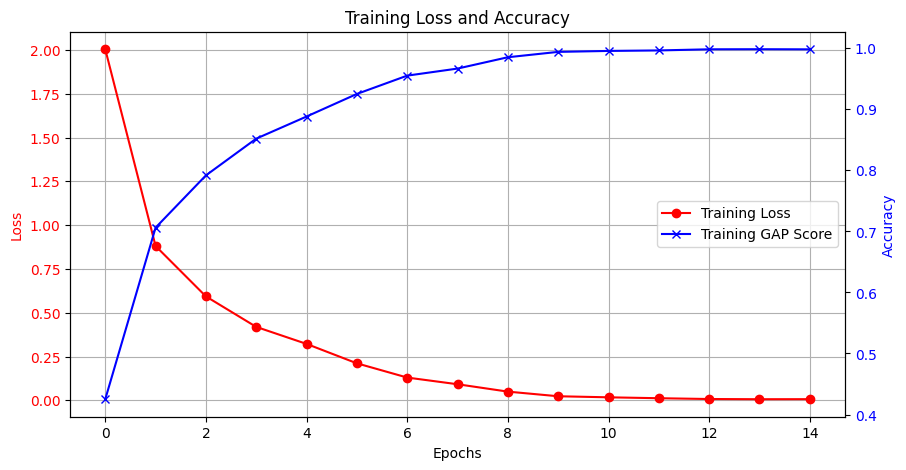

maximum accuracy achieved with 99.84779999999999% at epoch 14


In [15]:
# Plot losses
import numpy as np
# acc = [acc.item() for acc in train_accuracies]
plot_metrics(train_losses, train_gap)
print(f"maximum accuracy achieved with {round(max(train_gap), 6) * 100}% at epoch {np.argmax(train_gap) + 1}")

# Test and Eavluation

In [21]:
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0  # Track total samples processed

    with torch.no_grad():
        progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc="Evaluating", leave=True)
        for i, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels.data)
            total_samples += labels.size(0)

            # Update the progress bar with average loss and accuracy
            average_loss = running_loss / total_samples
            average_accuracy = correct_predictions.double() / total_samples
            progress_bar.set_postfix({'avg_loss': f'{average_loss:.4f}', 'avg_acc': f'{average_accuracy:.2f}'})

    total_loss = running_loss / len(dataloader)
    accuracy = correct_predictions.double() / len(dataloader.dataset)
    # print(f'Validation Loss: {total_loss}, Accuracy: {accuracy}')
    return total_loss, accuracy  # Optionally return metrics for further analysis


In [22]:
# Define transformations for the training data
test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


label_csv = "/content/drive/MyDrive/cs444-final-project/project/data/small_data/small_data.csv"
test_img_id_to_path_mapping = "/content/drive/MyDrive/cs444-final-project/project/data/small_data/test_img_id_to_path_mapping_drive.csv"
# Create an instance of the dataset
test_dataset = LandmarkImageDataset(
    annotations_file=label_csv,
    transform=train_transform,
    id_path_mapping=test_img_id_to_path_mapping
)

# Define the DataLoader
test_loader = DataLoader(dataset=test_dataset, batch_size=16, shuffle=False, num_workers=NUM_WORKERS)

model.to(device)
model.load_state_dict(torch.load(MODEL_SAVE_TO))

# Evaluate the model
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion, device)
print(f"\nTest Loss: {test_loss}, Test Accuracy: {test_accuracy}")


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Evaluating: 100%|██████████| 46/46 [00:03<00:00, 14.57it/s, avg_loss=0.0603, avg_acc=0.92]


Test Loss: 0.5629050697321477, Test Accuracy: 0.916047619047619
